In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Define dataset path
DATASET_PATH = '/content/drive/My Drive/preprocessed_frames'  # Change this to your actual dataset path

# Image Parameters
IMG_SIZE = 224  #
NUM_CLASSES = 65

# Load Images and Labels
images = []
labels = []
label_map = {}  # Mapping class names to numbers

for idx, class_name in enumerate(os.listdir(DATASET_PATH)):
    label_map[class_name] = idx  # Assign a number to each class
    class_path = os.path.join(DATASET_PATH, class_name)

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize
        images.append(img)
        labels.append(idx)

# Convert to NumPy Arrays
images = np.array(images).reshape(-1, IMG_SIZE, IMG_SIZE, 1).astype("float32") / 255.0
labels = np.array(labels)

# Split into Train & Test
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

print(f"Dataset loaded: {x_train.shape[0]} training samples, {x_test.shape[0]} testing samples.")


Dataset loaded: 9768 training samples, 2442 testing samples.


In [ ]:
from tensorflow.keras import layers, models, Sequential
import tensorflow as tf

def hybrid_model(input_shape):
    model = Sequential()
    # 1st convolution layer
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    # 2nd convolution layer
    model.add(layers.Conv2D(64, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    # 3rd convolution layer
    model.add(layers.Conv2D(128, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    # Global pooling layer
    model.add(layers.GlobalAveragePooling2D())
    return model

# Model parameters
input_shape = (224, 224, 1)
patch_size = 16
embedding_dim = 64
num_classes=65
# Build the hybrid model
input_tensor = layers.Input(shape=input_shape)
cnn_model = hybrid_model(input_shape)
cnn_output = cnn_model(input_tensor)

# Calculate patches
num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)

# Dense layer to get patch embeddings
x = layers.Dense(num_patches * embedding_dim, activation='relu')(cnn_output)
x = layers.Reshape((num_patches, embedding_dim))(x)

# ViT attention mechanism
vit_output = layers.MultiHeadAttention(num_heads=8, key_dim=embedding_dim)(x, x)
vit_output = layers.GlobalAveragePooling1D()(vit_output)

# Merge CNN and ViT outputs
merged = layers.Concatenate()([cnn_output, vit_output])

# Final classification layers
x = layers.Dense(512, activation='relu')(merged)
outputs = layers.Dense(65, activation='softmax')(x)

# Create the final model
model = models.Model(inputs=input_tensor, outputs=outputs)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128)       │     92,672 │ input_layer[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 12544)     │  1,618,176 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 196, 64)   │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 64)   │    132,672 │ reshape[0][0],    │
│ (MultiHeadAttentio… │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ multi_head_atten… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 192)       │          0 │ sequential[0][0], │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │     98,816 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 65)        │     33,345 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,975,681 (7.54 MB)

 Trainable params: 1,975,681 (7.54 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=105, batch_size=32)


Epoch 1/105
306/306 ━━━━━━━━━━━━━━━━━━━━ 36s 84ms/step - accuracy: 0.0180 - loss: 4.1246 - val_accuracy: 0.0160 - val_loss: 4.0996
Epoch 2/105
306/306 ━━━━━━━━━━━━━━━━━━━━ 25s 52ms/step - accuracy: 0.0185 - loss: 4.0901 - val_accuracy: 0.0143 - val_loss: 4.0949
Epoch 3/105
306/306 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.0188 - loss: 4.0814 - val_accuracy: 0.0180 - val_loss: 4.0882
Epoch 4/105
306/306 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.0217 - loss: 4.0774 - val_accuracy: 0.0184 - val_loss: 4.0687
Epoch 5/105
306/306 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - accuracy: 0.0223 - loss: 4.0532 - val_accuracy: 0.0160 - val_loss: 4.0484
Epoch 6/105
306/306 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - accuracy: 0.0267 - loss: 4.0380 - val_accuracy: 0.0270 - val_loss: 4.0316
Epoch 7/105
306/306 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - accuracy: 0.0283 - loss: 3.9855 - val_accuracy: 0.0238 - val_loss: 3.9771
Epoch 8/105
306/306 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - accuracy: 0.0339 - loss: 3

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7948 - loss: 0.7809

Test Accuracy: 77.68%


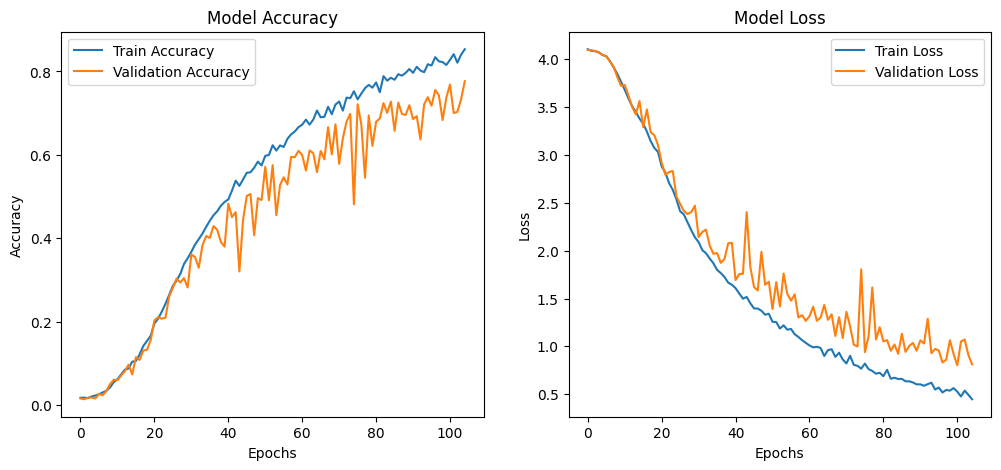

In [ ]:
import matplotlib.pyplot as plt

# Evaluate Model on Test Data
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"\nTest Accuracy: {test_acc * 100:.2f}%")

# Function to Plot Training History
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Model Accuracy")

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Model Loss")

    plt.show()

# Plot training results
plot_history(history)


In [ ]:
# Save to a specific folder
model.save('/content/drive/My Drive/Models/model.h5')
print("Model saved in '/content/drive/My Drive/Models/model.h5")

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from collections import Counter  # For majority voting

# Load the trained model
# model = load_model("/content/drive/My Drive/cnn_vit_model.h5")


# Define class labels (Update this based on your dataset)
class_labels = {
    0: "Good Morning",
    1: "Good Afternoon",
    2: "Hello",
    3: "How are you",
    4: "Thank you",
    5: "Are you free today",
    6: "Are you hiding something",
    7: "Help me",
    8: "How are things",
    9: "How can I help you",
    10: "How can I trust you",
    11: "How dare you",
    12: "How old are you",
    13: "I am (age)",
    14: "I am afraid of that",
    15: "I am crying",
    16: "I am feeling bored",
    17: "I am feeling cold",
    18: "I am fine. Thank you sir",
    19: "I am hungry",
    20: "I am in dilemma what to do",
    21: "I am not really sure",
    22: "I am really grateful",
    23: "I am sitting in the class",
    24: "I am so sorry to hear that",
    25: "I am suffering from fever",
    26: "I am tired",
    27: "I am very happy",
    28: "I can not help you there",
    29: "I do not agree",
    30: "I do not like it",
    31: "I do not mean it",
    32: "I don't agree",
    33: "I enjoyed a lot",
    34: "I got hurt",
    35: "I like you, I love you",
    36: "I need water",
    37: "I promise",
    38: "I really appreciate it",
    39: "I somehow got to know about it",
    40: "I was stopped by someone",
    41: "It does not make any difference to me",
    42: "It was nice chatting with you",
    43: "Let him take time",
    44: "My name is XXXXXXXX",
    45: "What are you doing",
    46: "What did you tell him",
    47: "What do you do",
    48: "What do you think",
    49: "What do you want to become",
    50: "What happened",
    51: "What have you planned for your career",
    52: "What is your phone number",
    53: "What do you want",
    54: "When will the train leave",
    55: "Where are you from",
    56: "Which college/school are you from",
    57: "Who are you",
    58: "Why are you angry",
    59: "Why are you crying",
    60: "Why are you disappointed",
    61: "You are bad",
    62: "You are good",
    63: "You are welcome",
    64: "You can do it"
}



# Function to preprocess frames
# Change target_size to match the model's input size
def preprocess_frame(frame, target_size=(224, 224)):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    frame = cv2.resize(frame, target_size)  # Resize to match model input
    frame = frame.astype("float32") / 255.0  # Normalize
    frame = np.expand_dims(frame, axis=-1)  # Add channel dimension
    return frame

# Function to extract frames from video
def extract_frames(video_path, max_frames=30):
    cap = cv2.VideoCapture(video_path)
    frames = []

    while len(frames) < max_frames:
        ret, frame = cap.read()
        if not ret:
            break  # End of video
        frame = preprocess_frame(frame)  # Preprocess the frame
        frames.append(frame)

    cap.release()
    # The shape will now be (num_frames, 224, 224, 1)
    return np.array(frames)

# Load video and preprocess frames
video_path = "/content/drive/My Drive/test_data/free2.mp4"  # Change this to your video file
frames = extract_frames(video_path)

# Loop through frames and predict each one individually
predictions = []
for frame in frames:
    # The frame is already (224, 224, 1), adding axis=0 makes it (1, 224, 224, 1)
    frame = np.expand_dims(frame, axis=0)
    prediction = model.predict(frame)
    predicted_class = np.argmax(prediction, axis=1)[0]  # Get class index
    predictions.append(predicted_class)

# Use majority voting to determine the final predicted class for the video
final_class_index = Counter(predictions).most_common(1)[0][0]
final_class_name = class_labels[final_class_index]  # Convert index to label

print(f"Final Predicted Class for Video: {final_class_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


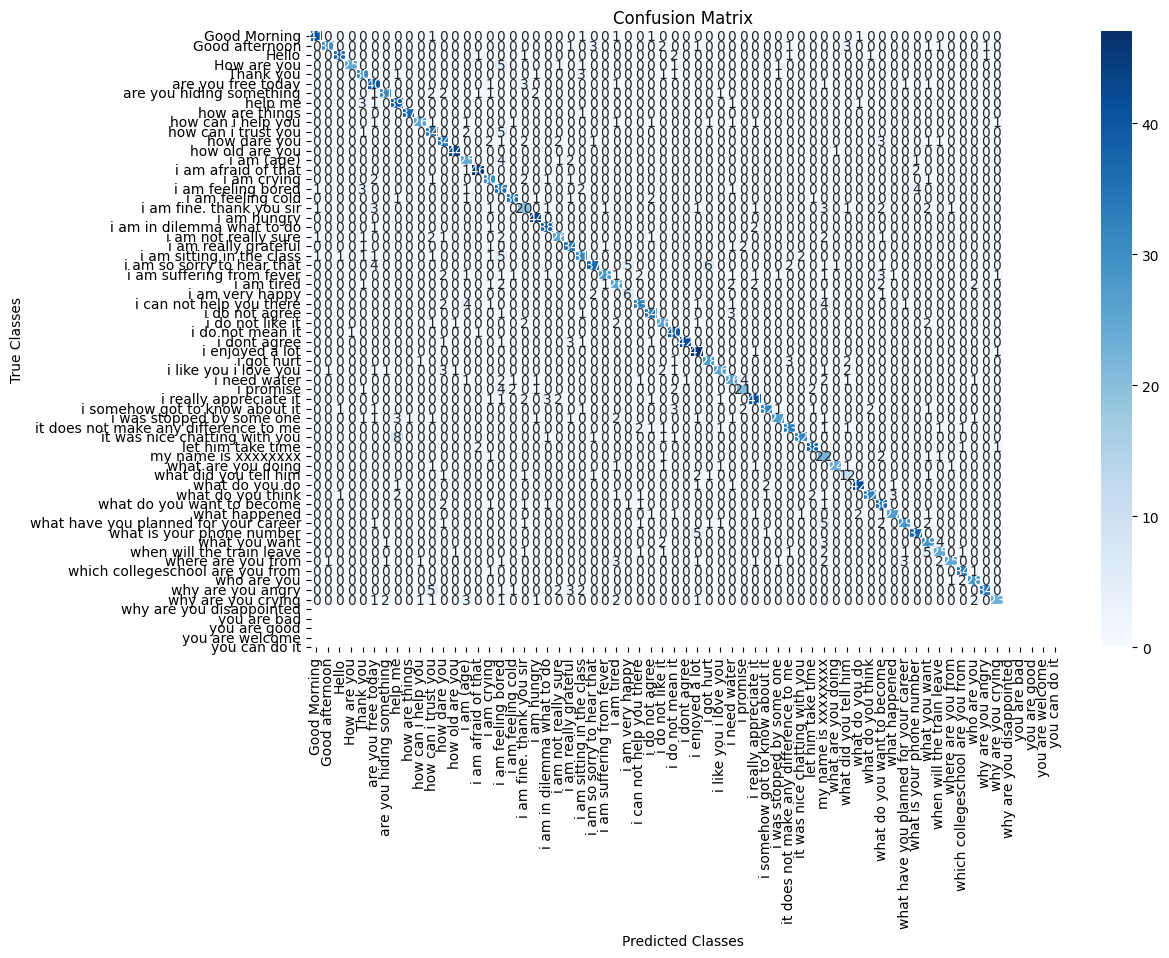

Classification Report:
                                       precision    recall  f1-score   support

                   are you free today       0.91      0.89      0.90        46
             are you hiding something       0.94      0.68      0.79        44
                              help me       0.93      0.84      0.88        45
                       how are things       0.96      0.74      0.83        34
                   how can i help you       0.70      0.79      0.74        38
                  how can i trust you       0.68      0.83      0.75        48
                         how dare you       0.86      0.76      0.81        41
                      how old are you       0.71      0.87      0.78        45
                           i am (age)       0.97      0.97      0.97        38
                  i am afraid of that       0.90      0.72      0.80        36
                          i am crying       0.67      0.81      0.73        42
                   i am feel

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Predict on the test dataset
y_pred_probs = model.predict(x_test)  # Predicted probabilities
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class indices
y_true_classes = np.argmax(y_test, axis=1)  # Convert one-hot encoded true labels to class indices

# Step 2: Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Step 3: Visualize the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_map.keys(),
            yticklabels=label_map.keys())
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.title("Confusion Matrix")
plt.show()

# Step 4: Generate and display classification report
# Get the unique class indices present in the true labels
unique_labels_in_test = np.unique(y_true_classes)

# Get the corresponding class names for the unique labels
# Ensure the order of target_names matches the order of unique_labels_in_test
target_names_for_test = [list(label_map.keys())[i] for i in unique_labels_in_test]

# Generate the classification report specifying the labels and target names
report = classification_report(y_true_classes, y_pred_classes,
                               labels=unique_labels_in_test,
                               target_names=target_names_for_test)
print("Classification Report:")
print(report)

In [ ]:
# Save to a specific folder
model.save('/content/drive/My Drive/Models/model.h5')
print("Model saved in '/content/drive/My Drive/Models/model.h5")

Model saved in '/content/drive/My Drive/Models/model.h5


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from collections import Counter  # For majority voting

# Load the trained model
model = load_model('/content/drive/My Drive/Models/model.h5')


# Define class labels (Update this based on your dataset)
class_labels = {
    0: "Good Morning",
    1: "Good Afternoon",
    2: "Hello",
    3: "How are you",
    4: "Thank you",
    5: "Are you free today",
    6: "Are you hiding something",
    7: "Help me",
    8: "How are things",
    9: "How can I help you",
    10: "How can I trust you",
    11: "How dare you",
    12: "How old are you",
    13: "I am (age)",
    14: "I am afraid of that",
    15: "I am crying",
    16: "I am feeling bored",
    17: "I am feeling cold",
    18: "I am fine. Thank you sir",
    19: "I am hungry",
    20: "I am in dilemma what to do",
    21: "I am not really sure",
    22: "I am really grateful",
    23: "I am sitting in the class",
    24: "I am so sorry to hear that",
    25: "I am suffering from fever",
    26: "I am tired",
    27: "I am very happy",
    28: "I can not help you there",
    29: "I do not agree",
    30: "I do not like it",
    31: "I do not mean it",
    32: "I don't agree",
    33: "I enjoyed a lot",
    34: "I got hurt",
    35: "I like you, I love you",
    36: "I need water",
    37: "I promise",
    38: "I really appreciate it",
    39: "I somehow got to know about it",
    40: "I was stopped by someone",
    41: "It does not make any difference to me",
    42: "It was nice chatting with you",
    43: "Let him take time",
    44: "My name is XXXXXXXX",
    45: "What are you doing",
    46: "What did you tell him",
    47: "What do you do",
    48: "What do you think",
    49: "What do you want to become",
    50: "What happened",
    51: "What have you planned for your career",
    52: "What is your phone number",
    53: "What do you want",
    54: "When will the train leave",
    55: "Where are you from",
    56: "Which college/school are you from",
    57: "Who are you",
    58: "Why are you angry",
    59: "Why are you crying",
    60: "Why are you disappointed",
    61: "You are bad",
    62: "You are good",
    63: "You are welcome",
    64: "You can do it"
}



# Function to preprocess frames
# Change target_size to match the model's input size
def preprocess_frame(frame, target_size=(224, 224)):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    frame = cv2.resize(frame, target_size)  # Resize to match model input
    frame = frame.astype("float32") / 255.0  # Normalize
    frame = np.expand_dims(frame, axis=-1)  # Add channel dimension
    return frame

# Function to extract frames from video
def extract_frames(video_path, max_frames=30):
    cap = cv2.VideoCapture(video_path)
    frames = []

    while len(frames) < max_frames:
        ret, frame = cap.read()
        if not ret:
            break  # End of video
        frame = preprocess_frame(frame)  # Preprocess the frame
        frames.append(frame)

    cap.release()
    # The shape will now be (num_frames, 224, 224, 1)
    return np.array(frames)

# Load video and preprocess frames
video_path = "/content/drive/My Drive/test_data/free2.mp4"  # Change this to your video file
frames = extract_frames(video_path)

# Loop through frames and predict each one individually
predictions = []
for frame in frames:
    # The frame is already (224, 224, 1), adding axis=0 makes it (1, 224, 224, 1)
    frame = np.expand_dims(frame, axis=0)
    prediction = model.predict(frame)
    predicted_class = np.argmax(prediction, axis=1)[0]  # Get class index
    predictions.append(predicted_class)

# Use majority voting to determine the final predicted class for the video
final_class_index = Counter(predictions).most_common(1)[0][0]
final_class_name = class_labels[final_class_index]  # Convert index to label

print(f"Final Predicted Class for Video: {final_class_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━

In [ ]:
from gtts import gTTS
from IPython.display import Audio

# Function to convert text to speech and save it as an MP3 file
def convert_text_to_speech(text, output_filename="predicted_audio.mp3"):
    # Creates TTS object from the predicted text
    tts = gTTS(text)
    # Save the speech as an MP3 file
    tts.save(output_filename)
    print(f"Audio saved as {output_filename}")
    return Audio(output_filename)

predicted_class_name = final_class_name

# Convert the predicted gesture to speech and play it
audio = convert_text_to_speech(predicted_class_name)
audio


Audio saved as predicted_audio.mp3


In [ ]:
! pip install gtts

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 11.6 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.2.0
    Uninstalling click-8.2.0:
      Successfully uninstalled click-8.2.0


In [ ]:


# Install TensorFlow.js
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.32.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
# Import libraries
import tensorflowjs as tfjs
from tensorflow.keras.models import load_model

# Load your model
model = load_model('/content/drive/My Drive/Models/model.h5')

# Convert and save the model to TensorFlow.js format
tfjs.converters.save_keras_model(model, '/content/drive/My Drive/Models/web_model')

print("Model converted successfully! Saved in '/content/drive/My Drive/Models/web_model'")


failed to lookup keras version from the file,
    this is likely a weight only file
Model converted successfully! Saved in '/content/drive/My Drive/Models/web_model'
